In [2]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint

import re
from bs4 import BeautifulSoup
#nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
df = pd.read_csv("merged_v2.csv")

In [69]:
df.dropna(subset=['file'],inplace = True)

In [70]:
df.dropna(subset=['3_day_buy_and_hold_return'],inplace = True)

In [6]:
with open('H4N-inf.txt') as f:
    lines = f.read().splitlines()

    wrds_h4 = [i.lower() for i in lines]


with open('Fin_Neg.txt') as f:
    lines_fin = f.read().splitlines()

    wrds_fin = [i.lower() for i in lines_fin]

In [7]:
def get_bag_of_words(sentiment_words, docs):

    vec = CountVectorizer(vocabulary=sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names()
    bag_of_words = np.zeros([len(docs), len(words_list)])
    
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]
    return bag_of_words.astype(int)

def get_tfidf(sentiment_words, docs):
    
    vec = TfidfVectorizer(vocabulary=sentiment_words)
    tfidf = vec.fit_transform(docs)
    
    return tfidf.toarray()

In [8]:
prop_h4 = get_bag_of_words(wrds_h4,df["file"])
tf_idf_weight_h4 = get_tfidf(wrds_h4,df["file"])


/Users/akshat/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
prop_fin = get_bag_of_words(wrds_fin,df["file"])
tf_idf_weight_fin = get_tfidf(wrds_fin,df["file"])

In [98]:
df['len_uni'] = df['file'].apply(lambda x: len(set(x.split())))


In [136]:
df["count_h4_IND"] = np.sum((prop_h4!=0).astype(int),axis=1)/df['len_uni']
df["count_fin_IND"] = np.sum((prop_fin!=0).astype(int),axis=1)/df['len_uni']

In [99]:
df['len'] = df['file'].apply(lambda x: len(x.split()))

In [11]:
prop_weight_h4 = np.multiply(prop_h4,tf_idf_weight_h4)
prop_weight_fin = np.multiply(prop_fin,tf_idf_weight_fin)

In [112]:
df['temp_h4'] = np.sum(tf_idf_weight_h4,axis = 1)
df['temp_fin'] = np.sum(tf_idf_weight_fin,axis = 1)
df['tfidf_h4_v2'] = (np.sum(prop_weight_h4_v2,axis = 1)/df['temp_h4'])/df['len']
df['tfidf_fin_v2'] = np.sum(prop_weight_fin_v2,axis = 1)/df['temp_fin']/df['len']
df['tfidf_h4'] = np.sum(prop_weight_h4,axis = 1)/df['len_uni']
df['tfidf_fin'] = np.sum(prop_weight_fin,axis = 1)/df['len_uni']

In [181]:
df['tfidf_h4_final'] = df['temp_h4']/df['len']
df['tfidf_fin_final'] = df['temp_fin']/df['len']

In [3]:
df_out = df[['ticker','date','3_day_buy_and_hold_excess_return','3_day_buy_and_hold_excess_log_return','tfidf_h4_v2','tfidf_fin_v2','count_h4_IND','count_fin_IND','tfidf_h4_final','tfidf_fin_final']]
df_out.rename(columns={"3_day_buy_and_hold_excess_return": "return"},inplace=True)


NameError: name 'df' is not defined

In [29]:
x_h4 = wrds_h4
y_h4 = np.sum((prop_h4!=0).astype(int),axis=0)
df_h4 = pd.DataFrame({'Words':x_h4, 'Count':y_h4})

x_fin = wrds_fin
y_fin = np.sum((prop_fin!=0).astype(int),axis=0)
df_fin = pd.DataFrame({'Words':x_fin, 'Count':y_fin})

y_fin_tf_idf = np.sum(prop_weight_fin,axis=0)
df_fin_tf_idf = pd.DataFrame({'Words':x_fin, 'Count':y_fin_tf_idf})

y_h4_tf_idf = np.sum(prop_weight_h4,axis=0)
df_h4_tf_idf = pd.DataFrame({'Words':x_h4, 'Count':y_h4_tf_idf})


In [38]:
df_h4.sort_values(by=["Count"],ascending=False).head(10)["Words"]

604         capital
3180           risk
2430           loss
3340          shell
890           costs
886            cost
2385    liabilities
3720            tax
3722          taxes
1664        expense
Name: Words, dtype: object

In [39]:
df_fin.sort_values(by=["Count"],ascending=False).head(10)["Words"]

1391          loss
1392        losses
71         adverse
1384    litigation
685      disclosed
1139    impairment
227         claims
2311    volatility
392       critical
1533      negative
Name: Words, dtype: object

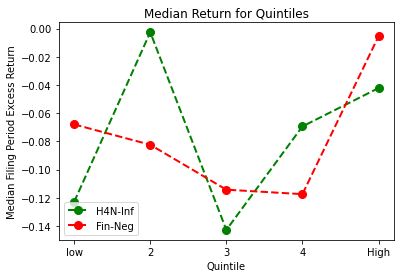

In [211]:
columns = ['count_h4_IND','count_fin_IND']
Quintile = ['low', '2', '3', '4','High']
for i in range(len(columns)):
#col = 'ratio_h4'
    col = columns[i]
    q = df_out.quantile([0.00, 0.2, 0.40, 0.6,0.8, 1.00])

    q1 = ((df_out[col]>=q[col][0.00]) & (df_out[col]<q[col][0.20]))
    q2 = ((df_out[col]>=q[col][0.20]) & (df_out[col]<q[col][0.40]))
    q3 = ((df_out[col]>=q[col][0.40]) & (df_out[col]<q[col][0.60]))
    q4 = ((df_out[col]>=q[col][0.60]) & (df_out[col]<q[col][0.80]))
    q5 = ((df_out[col]>=q[col][0.80]) & (df_out[col]<=q[col][1.00]))


    Median_Return[i] = [df_out[['return']][q1].median()[0]*100, df_out[['return']][q2].median()[0]*100, \
       df_out[['return']][q3].median()[0]*100, df_out[['return']][q4].median()[0]*100,df_out[['return']][q5].median()[0]*100]
  
    
    
plt.plot(Quintile,Median_Return[0],color='green', marker='o', linestyle='dashed',linewidth=2, markersize=8,label ="H4N-Inf")
plt.plot(Quintile,Median_Return[1],color='red', marker='o',linestyle='dashed',linewidth=2, markersize=8,label ="Fin-Neg")
plt.title('Median Return for Quintiles')
plt.xlabel('Quintile')
plt.ylabel('Median Filing Period Excess Return')
plt.legend()

In [213]:
new_date = df[q5]['datadate'].apply(lambda x: (pd.to_datetime(x).year, "Q"+str(pd.to_datetime(x).quarter)))
new_date.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

(2021, Q1)    9.0%
(2020, Q1)    8.0%
(2019, Q1)    7.6%
(2018, Q1)    7.1%
(2017, Q1)    6.8%
(2016, Q1)    6.2%
(2020, Q2)    4.8%
(2020, Q3)    4.1%
(2020, Q4)    3.8%
(2021, Q4)    3.2%
(2019, Q4)    3.1%
(2021, Q2)    3.0%
(2019, Q3)    3.0%
(2019, Q2)    3.0%
(2018, Q4)    2.9%
(2021, Q3)    2.9%
(2016, Q2)    2.8%
(2017, Q4)    2.7%
(2016, Q3)    2.7%
(2016, Q4)    2.7%
(2017, Q3)    2.7%
(2017, Q2)    2.6%
(2018, Q2)    2.6%
(2018, Q3)    2.5%
Name: datadate, dtype: object

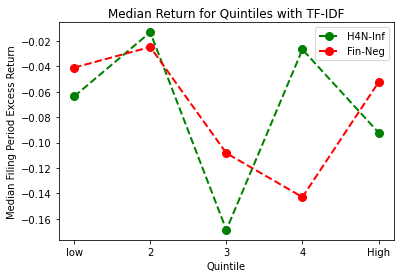

In [185]:
columns = ['tfidf_h4_final','tfidf_fin_final']
Quintile = ['low', '2', '3', '4','High']
for i in range(len(columns)):
#col = 'ratio_h4'
    col = columns[i]
    q = df_out.quantile([0.00, 0.2, 0.40, 0.6,0.8, 1.00])

    q1 = ((df_out[col]>=q[col][0.00]) & (df_out[col]<q[col][0.20]))
    q2 = ((df_out[col]>=q[col][0.20]) & (df_out[col]<q[col][0.40]))
    q3 = ((df_out[col]>=q[col][0.40]) & (df_out[col]<q[col][0.60]))
    q4 = ((df_out[col]>=q[col][0.60]) & (df_out[col]<q[col][0.80]))
    q5 = ((df_out[col]>=q[col][0.80]) & (df_out[col]<=q[col][1.00]))


    Median_Return[i] = [df_out[['return']][q1].median()[0]*100, df_out[['return']][q2].median()[0]*100, \
       df_out[['return']][q3].median()[0]*100, df_out[['return']][q4].median()[0]*100,df_out[['return']][q5].median()[0]*100]
  
    
    
plt.plot(Quintile,Median_Return[0],color='green', marker='o', linestyle='dashed',linewidth=2, markersize=8,label ="H4N-Inf")
plt.plot(Quintile,Median_Return[1],color='red', marker='o',linestyle='dashed',linewidth=2, markersize=8,label ="Fin-Neg")
plt.title('Median Return for Quintiles with TF-IDF')
plt.xlabel('Quintile')
plt.ylabel('Median Filing Period Excess Return')
plt.legend()

In [1]:
columns = ['tfidf_h4_v2','tfidf_fin_v2']
Quintile = ['low', '2', '3', '4','High']
for i in range(len(columns)):
#col = 'ratio_h4'
    col = columns[i]
    q = df_out.quantile([0.00, 0.2, 0.40, 0.6,0.8, 1.00])

    q1 = ((df_out[col]>=q[col][0.00]) & (df_out[col]<q[col][0.20]))
    q2 = ((df_out[col]>=q[col][0.20]) & (df_out[col]<q[col][0.40]))
    q3 = ((df_out[col]>=q[col][0.40]) & (df_out[col]<q[col][0.60]))
    q4 = ((df_out[col]>=q[col][0.60]) & (df_out[col]<q[col][0.80]))
    q5 = ((df_out[col]>=q[col][0.80]) & (df_out[col]<=q[col][1.00]))


    Median_Return[i] = [df_out[['return']][q1].median()[0]*100, df_out[['return']][q2].median()[0]*100, \
       df_out[['return']][q3].median()[0]*100, df_out[['return']][q4].median()[0]*100,df_out[['return']][q5].median()[0]*100]
  
    
    
plt.plot(Quintile,Median_Return[0],color='green', marker='o', linestyle='dashed',linewidth=2, markersize=8,label ="H4N-Inf")
plt.plot(Quintile,Median_Return[1],color='red', marker='o',linestyle='dashed',linewidth=2, markersize=8,label ="Fin-Neg")
plt.title('Median Return for Quintiles with TF-IDF')
plt.xlabel('Quintile')
plt.ylabel('Median Filing Period Excess Return')
plt.legend()

NameError: name 'df_out' is not defined

In [193]:
df2 = df[df['type'] == '10-Q']

In [ ]:
new_date = df2[q5]['datadate'].apply(lambda x: (pd.to_datetime(x).year, "Q"+str(pd.to_datetime(x).quarter)))
new_date.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'